<a href="https://colab.research.google.com/github/StepDaria/FaceGeneration/blob/main/gan_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
import shutil
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from collections import Counter
from torch.utils.data import Dataset
%matplotlib inline
from sklearn.manifold import TSNE

from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def get_dataloader(data_path, image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    transform = tt.Compose([
#         tt.RandomRotation(10),
        tt.RandomHorizontalFlip(p=0.5),
        #tt.Resize(image_size),
#         tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)
    ])

    dataset = ImageFolder(data_path, transform)

    print(dict(Counter(dataset.targets)))

    return DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
image_size = 128
batch_size = 64
data_path = '../input/flickrfaces-dataset-nvidia-128x128'

dataloader = get_dataloader(data_path, image_size, batch_size)

{0: 70000}


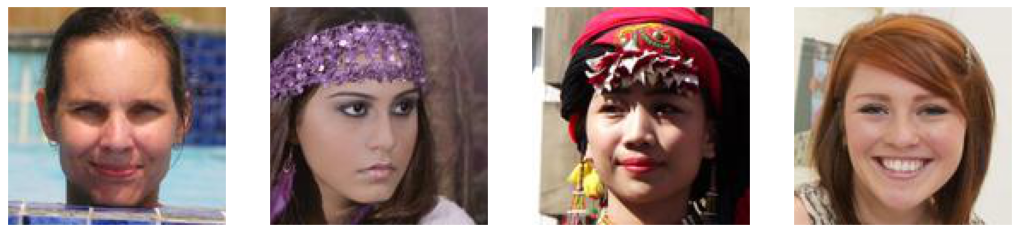

In [ ]:
plt.rcParams['figure.figsize'] = (18, 6)

def denorm(img):
    return img * stats[1][0] + stats[0][0]

def show_real_img(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg
    
dataiter = iter(dataloader)
images, _ = dataiter.next()

fig, axes = plt.subplots(1, 4)
for i, ax in enumerate(axes):
    ax.imshow(denorm(show_real_img(images[i])))
    ax.set_xticks([]); ax.set_yticks([])

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.in_features = 3 * image_size * image_size
    
        self.discriminator = nn.Sequential(
                GaussianNoise(),
                nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),  # 32 x 64 x 64
                #nn.BatchNorm2d(32),
                nn.LeakyReLU(inplace=True),
                
                GaussianNoise(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False), # 64 x 32 x 32
                #nn.BatchNorm2d(64),
                nn.LeakyReLU(inplace=True),
                
                GaussianNoise(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 128 x 16 x 16
                #nn.BatchNorm2d(128),
                nn.LeakyReLU(inplace=True),
            
                GaussianNoise(),
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 256 x 8 x 8
                #nn.BatchNorm2d(256),
                nn.LeakyReLU(inplace=True),
                
                GaussianNoise(),
                nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # 512 x 4 x 4
                #nn.BatchNorm2d(512),
                nn.LeakyReLU(inplace=True),

                GaussianNoise(),
                nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), # 1 x 1 x 1

                nn.Flatten(),
                nn.Sigmoid()
        )

    def forward(self, x):
        x = self.discriminator(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_code):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
        nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False), # 1024 x 4 x 4
        nn.BatchNorm2d(1024),
        nn.Dropout(0.3),
        nn.LeakyReLU(0.2, True),

        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # 512 x 8 x 8
        nn.BatchNorm2d(512),
        nn.Dropout2d(0.3),
        nn.LeakyReLU(0.2, True),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), # 256 x 16 x 16
        nn.BatchNorm2d(256),
        nn.Dropout2d(0.3),
        nn.LeakyReLU(0.2, True),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 128 x 32 x 32
        nn.BatchNorm2d(128),
        nn.Dropout2d(0.3),
        nn.LeakyReLU(0.2, True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 64 x 64 x 64
        nn.BatchNorm2d(64),
        nn.Dropout2d(0.3),
        nn.LeakyReLU(0.2, True),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), # 3 x 128 x 128
        nn.Tanh()
    )

    def forward(self, x):
        x = self.generator(x)
        return x

In [ ]:
discriminator = Discriminator().to(device)

latent_size = 128
generator = Generator(latent_size).to(device)

In [ ]:
discriminator_total_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
generator_total_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)

discriminator_total_params, generator_total_params

(2795008, 13245312)

In [ ]:
def show_images(generated):
    # TODO: show generated images
    generated = generated.permute(0, 2, 3, 1).detach().cpu().numpy()
    generated = denorm(generated)
    fig, axes = plt.subplots(1, generated.shape[0])
    for i, ax in enumerate(axes):
        ax.imshow(generated[i])
        ax.set_xticks([]); ax.set_yticks([])
    plt.show()

In [ ]:
lr = 0.0001
epochs = 25

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
plt.rcParams['figure.figsize'] = (18, 6)
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    logs = []

    # Create optimizers
    optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                        lr=lr, betas=(0.5, 0.999)),
      "generator": torch.optim.Adam(model["generator"].parameters(),
                                    lr=2*lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in dataloader:

            #### discriminator ####
            real_images = real_images.to(device)
            optimizer["discriminator"].zero_grad()
            disc_preds_of_real = model["discriminator"](real_images)
            real_labels = torch.ones(real_images.shape[0], 1, device=device)
            disc_loss_of_real = criterion['discriminator'](disc_preds_of_real, real_labels)
            cur_real_score = torch.mean(disc_preds_of_real).item()

            # generation of fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model['generator'](latent)

            disc_preds_of_fake = model['discriminator'](fake_images)
            fake_labels = torch.zeros(fake_images.shape[0], 1, device=device)
            disc_loss_of_fake = criterion['discriminator'](disc_preds_of_fake, fake_labels)
            cur_fake_score = torch.mean(disc_preds_of_fake).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = disc_loss_of_real + disc_loss_of_fake
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            #### generator ####

            # generation of fake images
            optimizer['generator'].zero_grad()
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model['generator'](latent)

            disc_preds = model['discriminator'](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion['generator'](disc_preds, targets)
            loss_g.backward()
            optimizer['generator'].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_d.append(np.mean(loss_d_per_epoch))
        losses_g.append(np.mean(loss_g_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        clear_output(wait=True)
        logs.append(f'Epoch {epoch + 1} of {epochs}.\
                      loss_d: {losses_d[-1]:.4f}, loss_g: {losses_g[-1]:.4f},\
                      real_score: {real_scores[-1]:.4f}, fake_score: {fake_scores[-1]:.4f}\n ')
        print(*logs)

        show_images(fake_images[:6])

    return {'losses_d': losses_d, 'losses_g': losses_g, 'real_scores': real_scores, 'fake_scores': fake_scores}

Epoch 1 of 25.                      loss_d: 1.3415, loss_g: 0.8499,                      real_score: 0.5060, fake_score: 0.4663
  Epoch 2 of 25.                      loss_d: 1.3763, loss_g: 0.7359,                      real_score: 0.5030, fake_score: 0.4923
  Epoch 3 of 25.                      loss_d: 1.3811, loss_g: 0.7237,                      real_score: 0.5012, fake_score: 0.4946
  Epoch 4 of 25.                      loss_d: 1.3829, loss_g: 0.7185,                      real_score: 0.5011, fake_score: 0.4965
  Epoch 5 of 25.                      loss_d: 1.3733, loss_g: 0.7494,                      real_score: 0.5059, fake_score: 0.4936
  Epoch 6 of 25.                      loss_d: 1.2852, loss_g: 0.9490,                      real_score: 0.5422, fake_score: 0.4595
  Epoch 7 of 25.                      loss_d: 1.2004, loss_g: 1.0262,                      real_score: 0.5717, fake_score: 0.4224
  Epoch 8 of 25.                      loss_d: 1.1436, loss_g: 1.0755,                      r

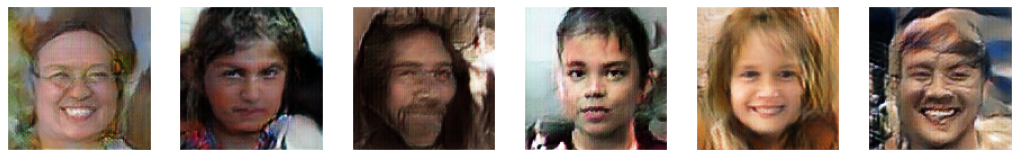

In [ ]:
history = fit(model, criterion, epochs, lr)

In [ ]:
torch.save(model['discriminator'], 'disc.model')
torch.save(model['generator'], 'gen.model')

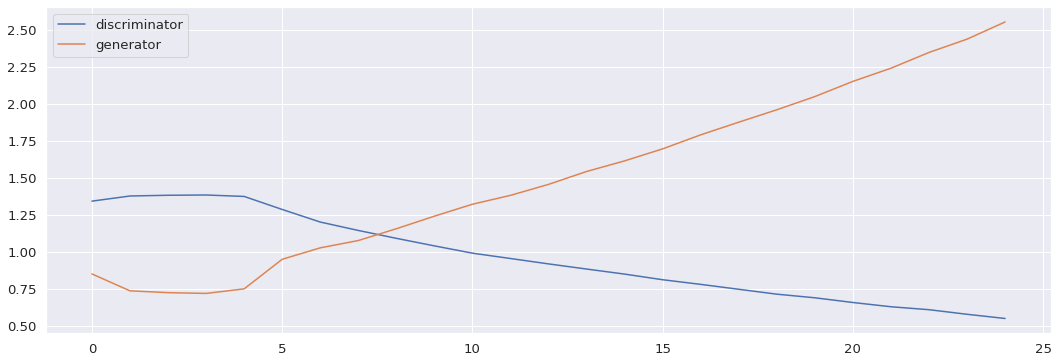

In [ ]:
plt.plot(history['losses_d'], label='discriminator')
plt.plot(history['losses_g'], label='generator')
plt.legend()
plt.show()

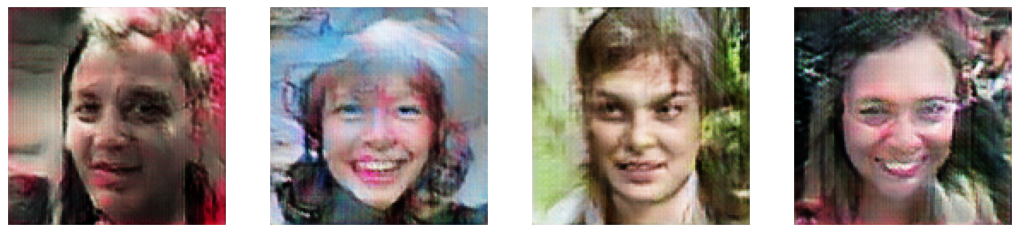

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
show_images(fake_images)

In [ ]:
num_of_images = 70000
class LatentDataset(Dataset):
    def __init__(self, num_of_images):
        self.num = num_of_images

    def __len__(self):
        return self.num

    def __getitem__(self, idx):
        label = torch.zeros(1, 1, 1, device=device)
        vector = torch.randn(latent_size, 1, 1, device=device)
        return vector, label

In [ ]:
fake_dataset = LatentDataset(num_of_images)
fake_dataloader = DataLoader(fake_dataset, batch_size=batch_size)

In [ ]:
images = torch.empty((0, 3, image_size, image_size))
with torch.no_grad():
    i = 0
    for vector, _ in fake_dataloader:
        if i < 6:
            images = torch.cat((images, model['generator'](vector).detach().cpu()), axis=0)
            i += 1
        else:
            break
            
i = 0
for img, _ in dataloader:
    if i < 6:
        images = torch.cat((images, img), axis=0)
        i += 1
    else:
        break

In [ ]:
y = np.concatenate((np.zeros(i * batch_size), np.ones(i * batch_size)), axis=0)

In [ ]:
def loo_score(images, labels):
    images = images.numpy()
    images = images.reshape((images.shape[0], -1))
    knn = KNeighborsClassifier(n_neighbors=1)
    loo = LeaveOneOut()

    actual = np.empty((0))
    predicted = np.empty((0))

    for train_index, test_index in loo.split(images):
        X_train, X_test = images[train_index], images[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
  
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Append the single predictions and actual values here.
        actual = np.append(actual, y_test[0])
        predicted = np.append(predicted, y_pred[0])
    print('loo score:', (actual == predicted).mean())
    return actual, predicted

In [ ]:
actual, predicted = loo_score(images, y)

loo score: 0.5546875


In [ ]:
def plot_TSNE(images, y):
    images = images.numpy()
    images = images.reshape((images.shape[0], -1))
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(images)
    plt.rcParams["figure.figsize"] = (18, 9)
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y, cmap='viridis')
    plt.legend(handles=scatter.legend_elements()[0], labels=[0, 1])
    plt.show()

In [ ]:
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

# замораживаем все парамеры
for param in alexnet_model.parameters():
    param.requires_grad = False

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
alexnet_model.eval()
with torch.no_grad():
    alexnet_features = alexnet_model.features(images)

In [ ]:
actual, predicted = loo_score(alexnet_features, y)

loo score: 0.6861979166666666


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


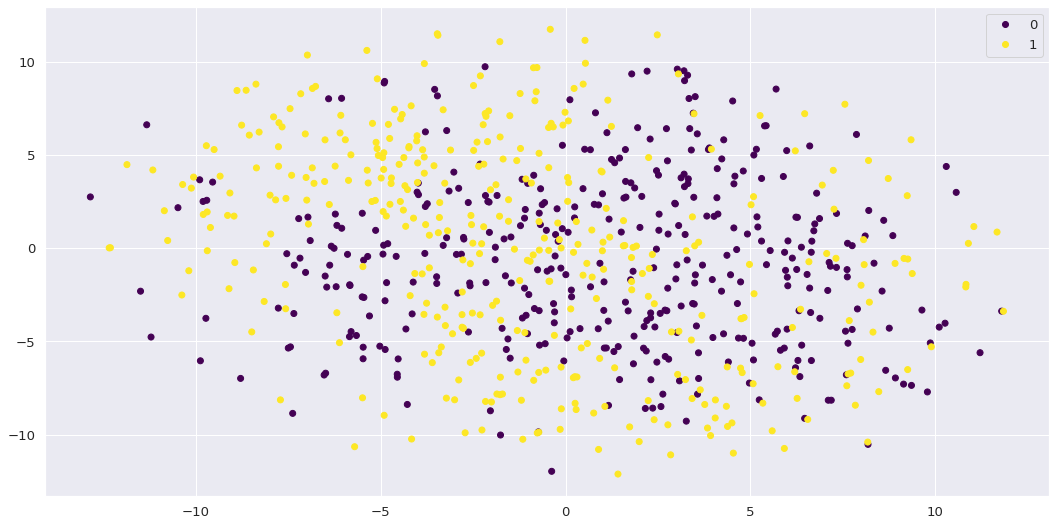

In [ ]:
plot_TSNE(alexnet_features, y)